In [367]:
%matplotlib inline
import numpy as np
import quantstats as qs
import pandas as pd
import yfinance as _yf
from pandas.tseries.offsets import MonthEnd

# Override function to use adjusted close, not Close
# https://github.com/ranaroussi/quantstats/blob/main/quantstats/utils.py#L233
def download_returns(ticker, period="max", proxy=None):
    params = {
        "tickers": ticker,
        "proxy": proxy,
    }
    if isinstance(period, pd.DatetimeIndex):
        params["start"] = period[0]
    else:
        params["period"] = period

    returns = _yf.download(**params)["Adj Close"].pct_change()
    return returns 

# extend pandas functionality with metrics, etc.
qs.extend_pandas()

# fetch the daily returns for a stock
# ^IRX: Risk Free Rate (daily or annualized?) (based on 3-Month US Treasury Bills Rates): https://gist.github.com/ranaroussi/72d0e92bbe31d1514baccf00175049e4
stocks = [(
    # qs.utils.download_returns(t)
    download_returns(t)
    .reset_index()
    .assign(returns=lambda df: 1+df['Adj Close'])
    .drop(columns=['Adj Close'])
    .set_index(['Date'])
    .resample('ME')
    .prod()
    .assign(returns=lambda df: df['returns']-1)
    .reset_index()
    .assign(id=t)
    ) for t in ['SPY']]
stocks += [
    (
        (_yf.download("^IRX")["Adj Close"]/100)
        .reset_index()
        .assign(returns=lambda df: (1+df['Adj Close']) ** (1/252))
        .drop(columns=['Adj Close'])
        .set_index(['Date'])
        .resample('ME')
        .apply(lambda df: df['returns'].prod() - 1)
        .reset_index()
        .rename(columns={0: 'returns'})
        .assign(id='IRX')
    )
]
# stock.name = 'returns'
# stock2 = qs.utils.download_returns('BIL')
# stock2.name = 'returns'
stocks[1].tail(3)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Date   returns   id
769 2024-02-29  0.004051  IRX
770 2024-03-31  0.004052  IRX
771 2024-04-30  0.003038  IRX

In [371]:
# data_filename_socgen = "lc_investing/data/socgen_trend_index_returns.xlsx"
data_filename_socgen = "c:\\Users\\Emile\\Documents\\lifecycle_investing\\lc_investing\\data\\socgen_trend_index_returns.xlsx"
trend_socgen = (
    pd.read_excel(data_filename_socgen)
    .drop(columns=['index level'])
    .rename(columns={'SG Trend Index': 'returns'})
    .assign(Date=lambda df: df['Date'] - MonthEnd(1))
    .assign(id='SG')
    # .set_index('Date')
)
# returns for various portfolios
data = (
    pd.concat(stocks+[trend_socgen], axis=0)
    .pivot(index='Date', columns='id', values='returns')
    .assign(IRX=lambda df: df['IRX']+ (0.0050/12))  # add 50 basis points to borrowing rate due to this blog post: https://www.returnstacked.com/return-stacking-and-the-cost-of-leverage/
    .assign(stocks_trend_m100_100_100=lambda df: (df[['IRX', 'SG', 'SPY']]*np.array([-1,1,1])).sum(axis=1))
    # .assign(stocks_trend_0_100_100=lambda df: (df[['IRX', 'SG', 'SPY']]*np.array([0,1,1])).sum(axis=1)) # zero borrowing cost
    .assign(stocks_trend_m100_0_200=lambda df: (df[['IRX', 'SG', 'SPY']]*np.array([-1,0,2])).sum(axis=1))
    .dropna()
)
# buy and hold portfolio
# from: https://bookdown.org/compfinezbook/introFinRbook/Return-Calculations.html#no-rebalancing-of-portolio-weights
bnh_returns_1 = (
    ((1 + data[['IRX', 'SG', 'SPY']]).cumprod() * np.array([-1, 0, 2]))  # values = initial_weights x cumulative returns
    .assign(m100_0_200_buy_n_hold=lambda df: (df[['IRX', 'SG', 'SPY']].divide(df[['IRX', 'SG', 'SPY']], axis=0) * data[['IRX', 'SG', 'SPY']]).sum(axis=1))  # weights x returns, then sum over assets
    .loc[:, ['m100_0_200_buy_n_hold']]
)
bnh_returns_2 = (
    ((1 + data[['IRX', 'SG', 'SPY']]).cumprod() * np.array([-1, 1, 1]))  # values = initial_weights x cumulative returns
    .assign(m100_100_100_buy_n_hold=lambda df: (df[['IRX', 'SG', 'SPY']].divide(df[['IRX', 'SG', 'SPY']], axis=0) * data[['IRX', 'SG', 'SPY']]).sum(axis=1))  # weights x returns, then sum over assets
    .loc[:, ['m100_100_100_buy_n_hold']]
)


data1 = (
    data
    .merge(bnh_returns_1,
           on="Date",
           how="left")
    .merge(bnh_returns_2,
           on="Date",
           how="left")
    .drop(columns=['SPY', 'IRX'])
)
print(data.tail(2))
data1.tail(3)

id               IRX        SG       SPY  stocks_trend_m100_100_100  \
Date                                                                  
2024-02-29  0.004468  0.064375  0.052187                   0.112094   
2024-03-31  0.004469  0.040084  0.032702                   0.068317   

id          stocks_trend_m100_0_200  
Date                                 
2024-02-29                 0.099906  
2024-03-31                 0.060935  


id                SG  stocks_trend_m100_100_100  stocks_trend_m100_0_200  \
Date                                                                       
2024-01-31  0.018186                   0.029454                 0.027195   
2024-02-29  0.064375                   0.112094                 0.099906   
2024-03-31  0.040084                   0.068317                 0.060935   

id          m100_0_200_buy_n_hold  m100_100_100_buy_n_hold  
Date                                                        
2024-01-31               0.020584                 0.038770  
2024-02-29               0.056655                 0.121029  
2024-03-31               0.037171                 0.077254

In [372]:
qs.reports.html(data1, benchmark="SPY")

[*********************100%%**********************]  1 of 1 completed


c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  r

[*********************100%%**********************]  1 of 1 completed


c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  r

                           Benchmark    SG          stocks_trend_m100_100_100    stocks_trend_m100_0_200    m100_0_200_buy_n_hold    m100_100_100_buy_n_hold
-------------------------  -----------  ----------  ---------------------------  -------------------------  -----------------------  -------------------------
Start Period               2000-01-31   2000-01-31  2000-01-31                   2000-01-31                 2000-01-31               2000-01-31
End Period                 2024-03-31   2024-03-31  2024-03-31                   2024-03-31                 2024-03-31               2024-03-31
Risk-Free Rate             0.0%         0.0%        0.0%                         0.0%                       0.0%                     0.0%
Time in Market             100.0%       100.0%      100.0%                       100.0%                     100.0%                   100.0%

Cumulative Return          255.51%      311.72%     1,271.45%                    894.82%                    831.27%  

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2015-03-31  2018-12-31  2021-02-28  2162    -20.687998        -20.055405
2  2004-02-29  2004-07-31  2006-02-28   731    -17.525229        -17.342971
3  2001-10-31  2002-03-31  2002-05-31   213    -16.268003        -14.401454
4  2000-02-29  2000-08-31  2000-10-31   246    -15.636535        -12.914042
5  2011-04-30  2014-02-28  2014-09-30  1250    -15.164284        -14.954886

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2008-06-30  2009-02-28  2010-11-30   884    -45.522504        -42.356144
2  2001-02-28  2002-09-30  2003-09-30   945    -29.752929        -27.919331
3  2011-04-30  2011-09-30  2012-03-31   337    -23.141299        -14.883740
4  2018-01-31  2018-12-31  2019-05-31   486    -21.777486        -15.075306
5  2022-04-30  2023-02-28  2024-01-31   642    -19.600936        -18.607861

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2000-04-30  2009-02-28  2013-06-30  4810    -80.896693        -75.648249
2  2022-01-31  2022-09-30  2024-01-31   731    -45.328371        -38.180531
3  2020-01-31  2020-03-31  2020-07-31   183    -37.177325        -21.254235
4  2018-10-31  2018-12-31  2019-03-31   152    -26.927382        -15.398692
5  2015-08-31  2015-09-30  2016-04-30   244    -16.753045        -15.081849

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2007-11-30  2009-02-28  2012-01-31  1524    -49.480089        -45.241419
2  2000-09-30  2002-09-30  2005-06-30  1735    -40.323515        -37.300426
3  2022-01-31  2022-09-30  2023-05-31   486    -22.851317        -19.499164
4  2020-02-29  2020-03-31  2020-06-30   123    -19.222275         -8.923865
5  2018-10-31  2018-12-31  2019-03-31   152    -12.902249         -6.667209

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2008-06-30  2009-02-28  2010-10-31   854    -44.353067        -41.053039
2  2001-02-28  2001-10-31  2003-03-31   762    -23.380487        -22.292514
3  2011-04-30  2011-09-30  2012-03-31   337    -22.717764        -14.348766
4  2018-09-30  2018-12-31  2019-02-28   152    -19.693135        -12.433254
5  2004-02-29  2004-07-31  2004-10-31   246    -18.235234        -16.135930

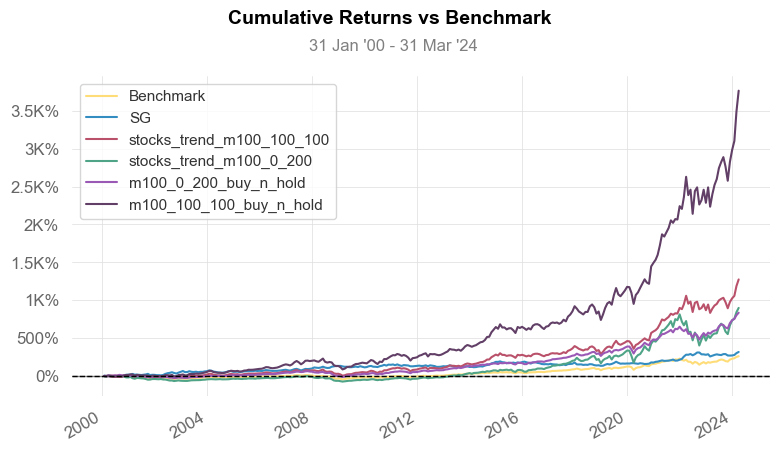

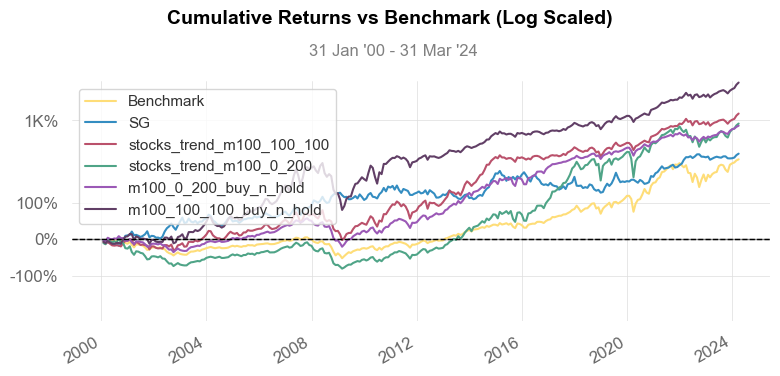

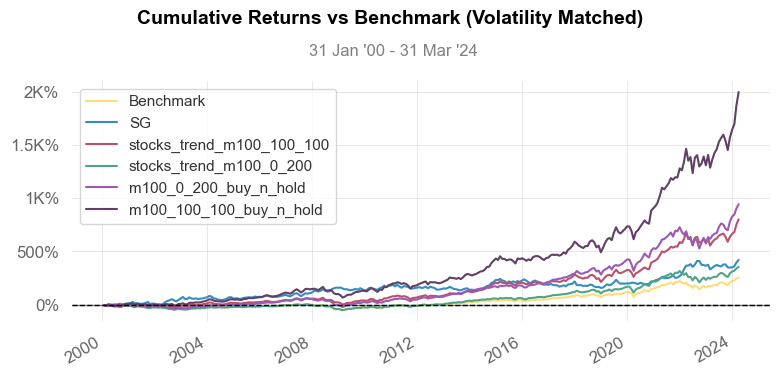

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\wrappers.py:555: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\wrappers.py:557: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  .resample("A")
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\wrappers.py:565: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").apply(_stats.comp)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\wrappers.py:568: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  returns = returns.resample("A").last()


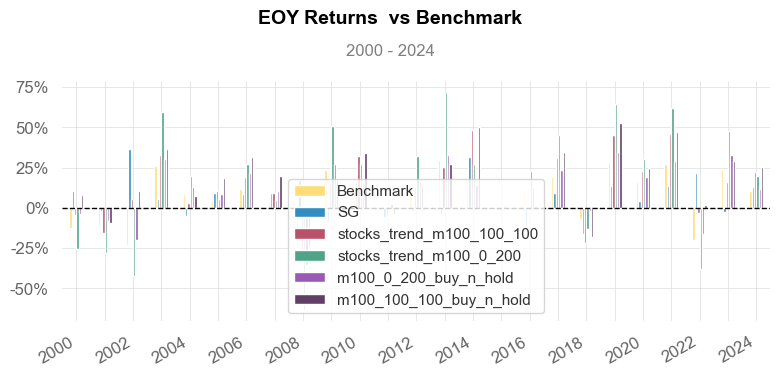

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:433: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:435: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample(resample)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns.fillna(0).resample(resample).apply(apply_fnc).resample(resample).last()


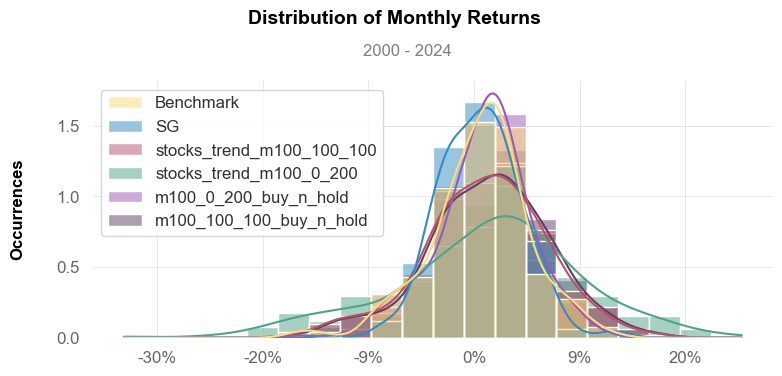

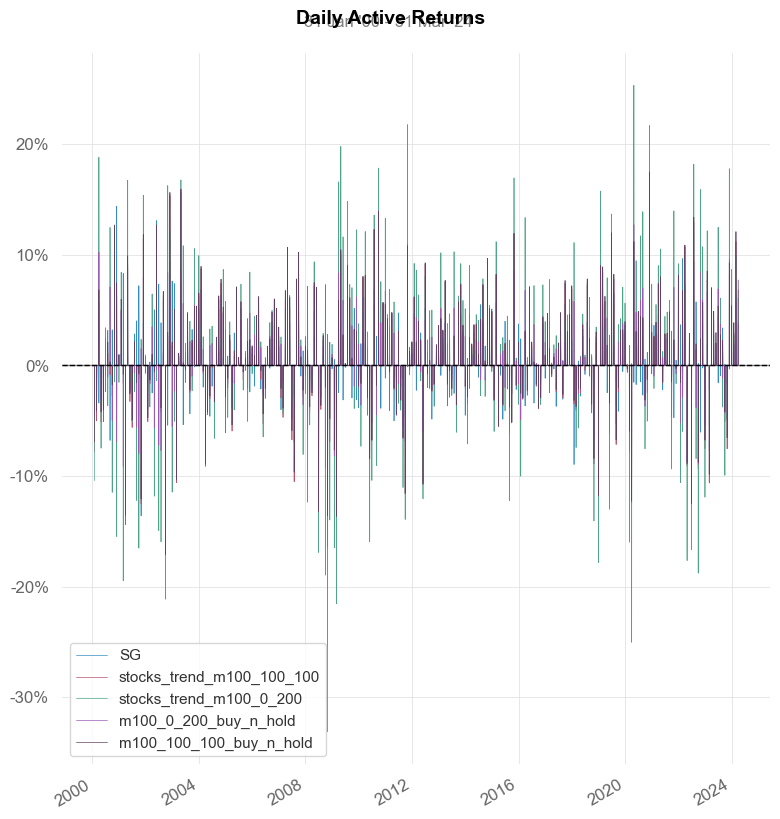

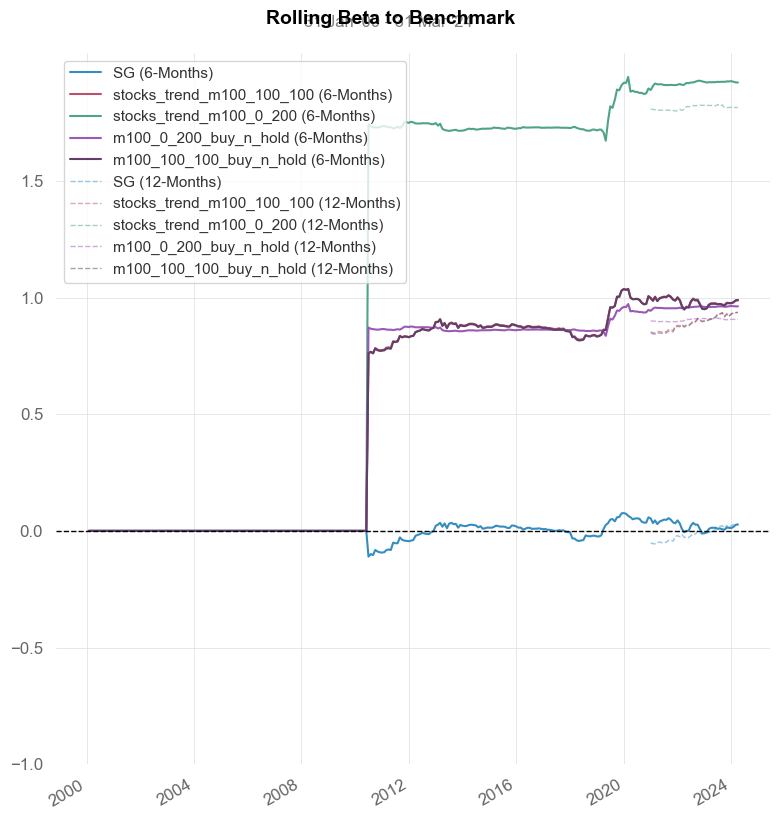

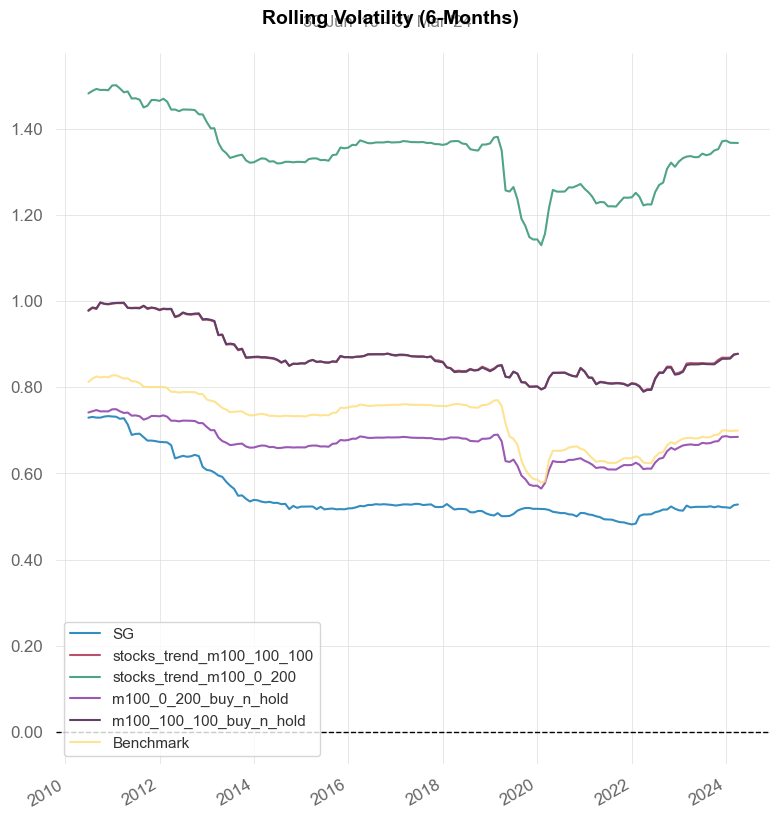

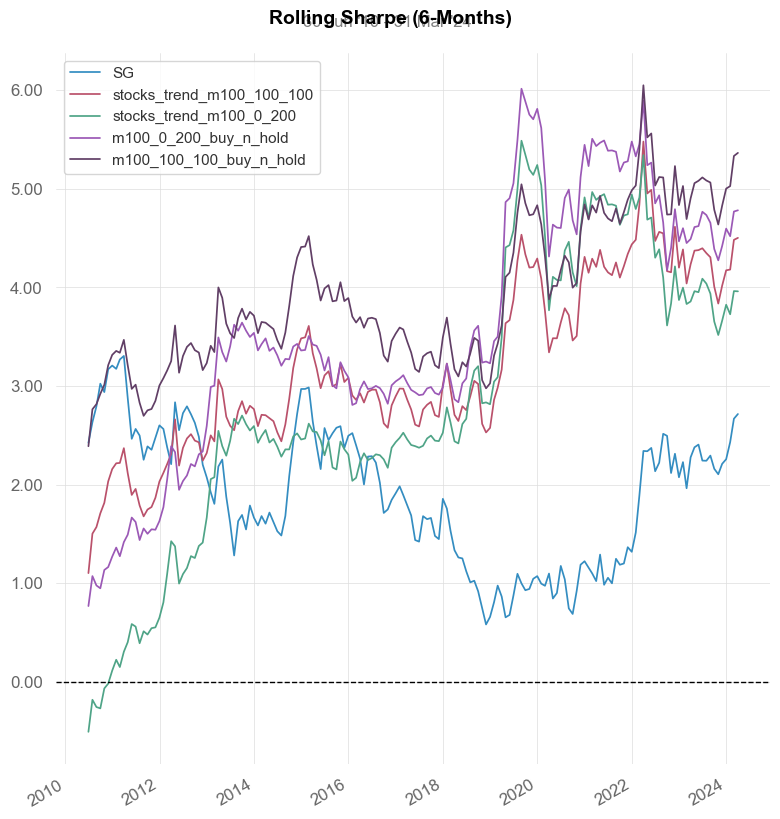

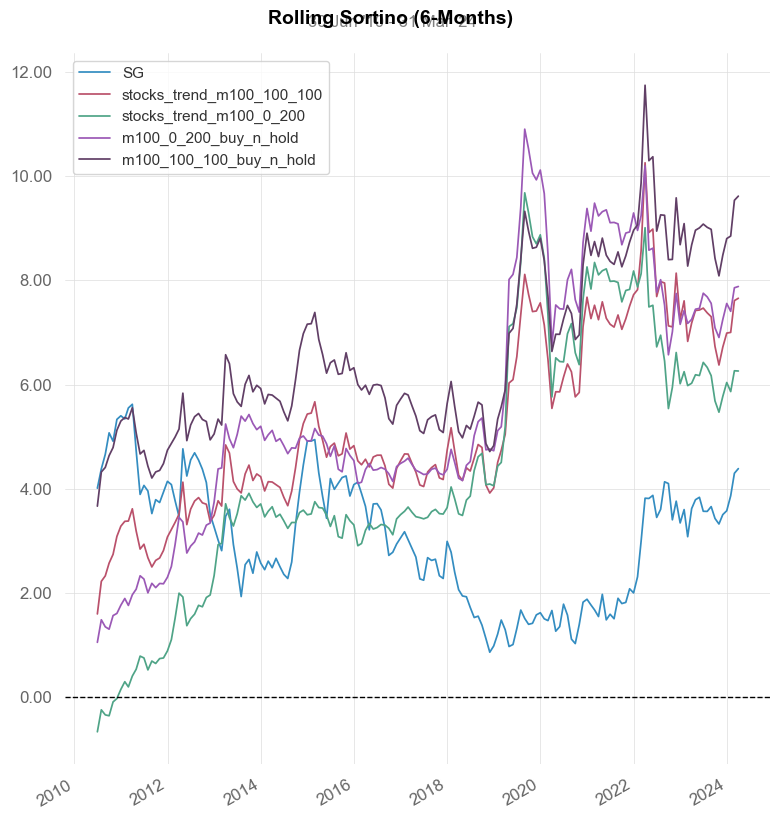

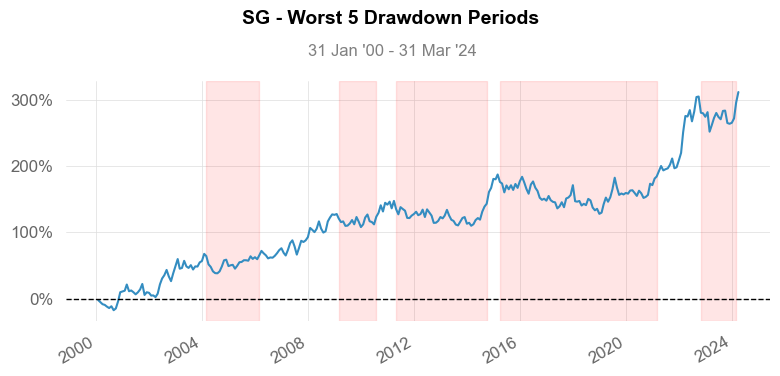

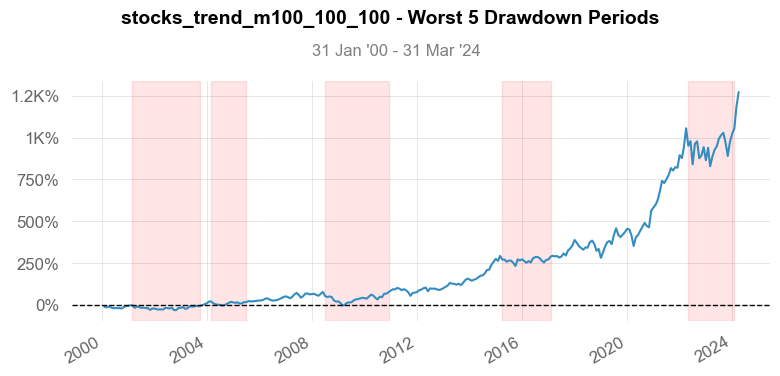

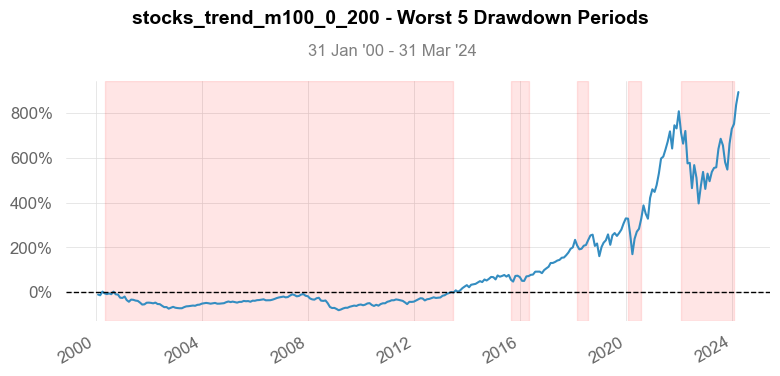

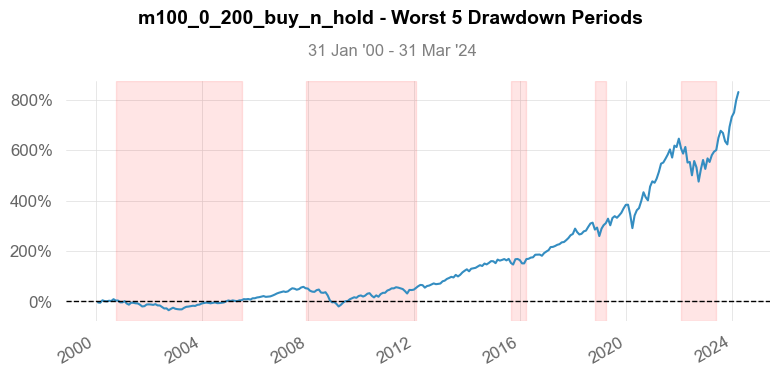

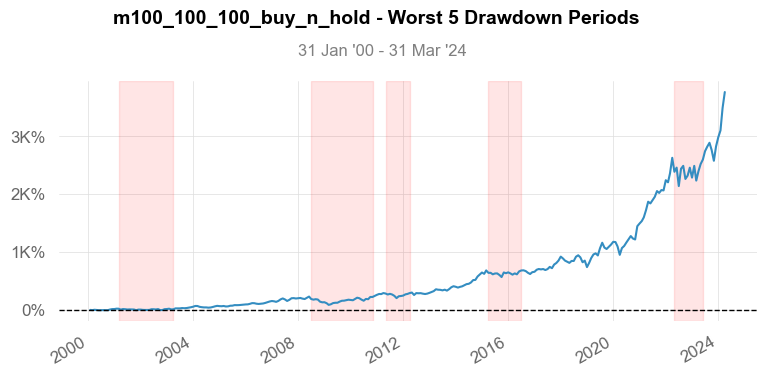

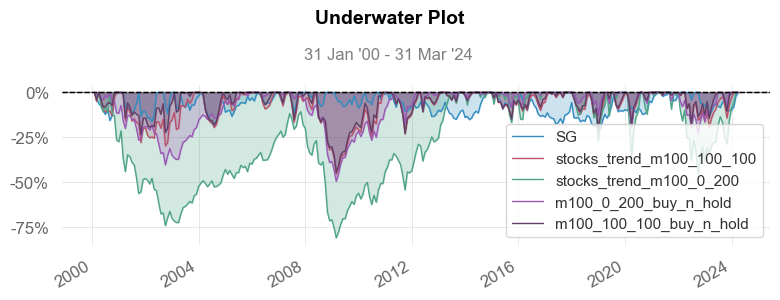

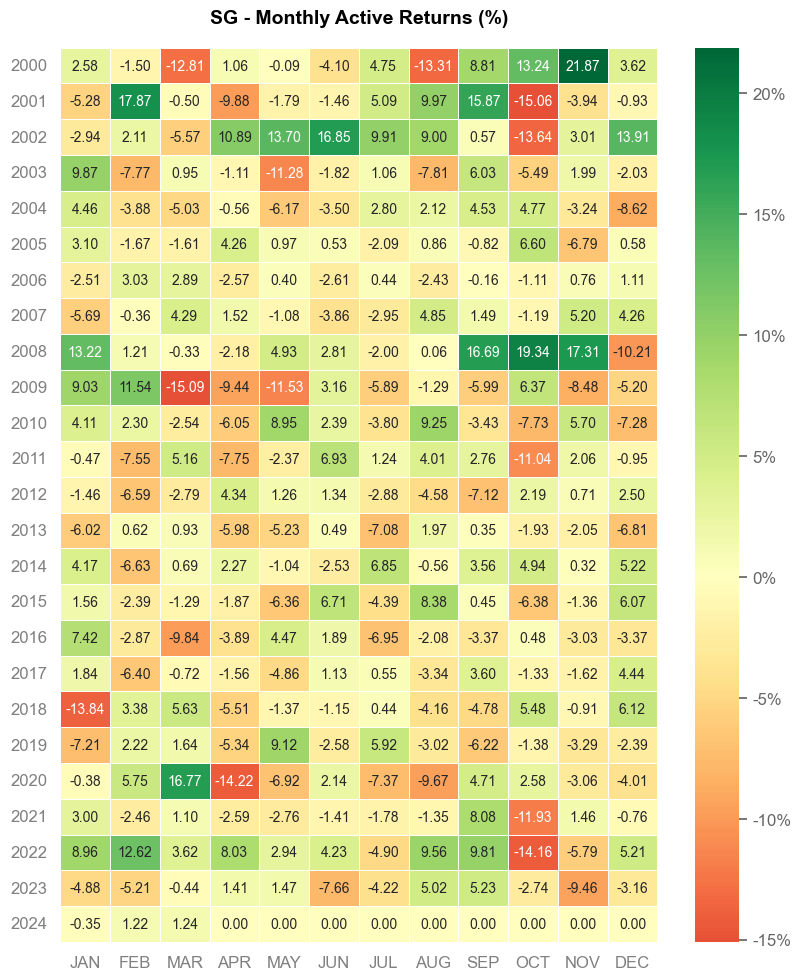

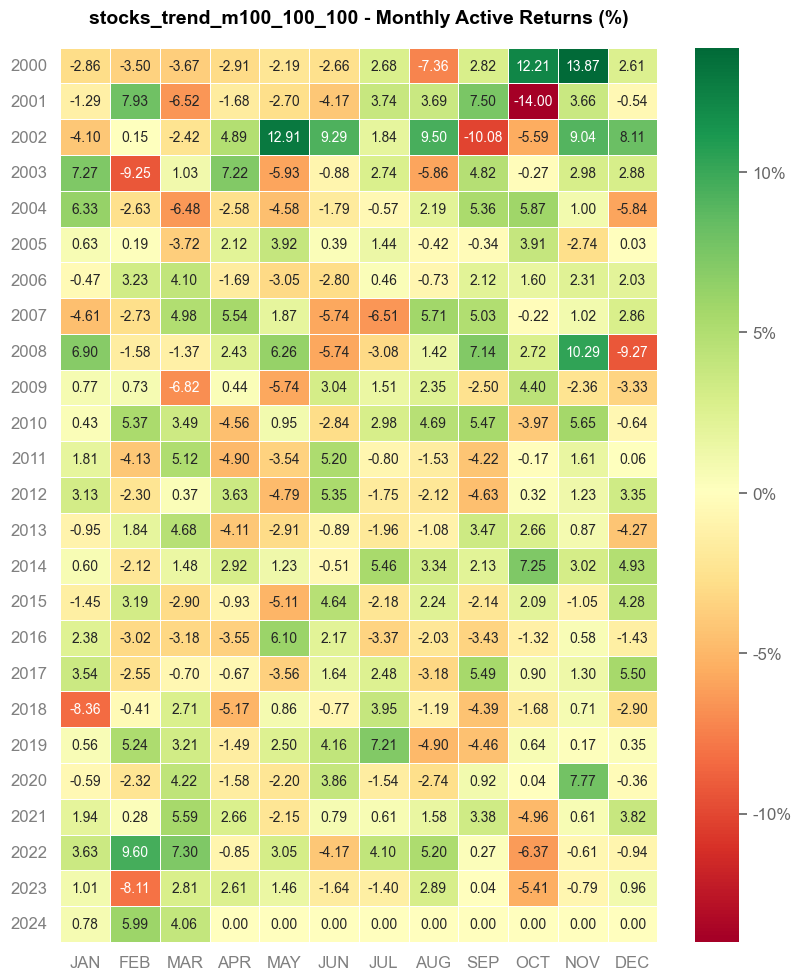

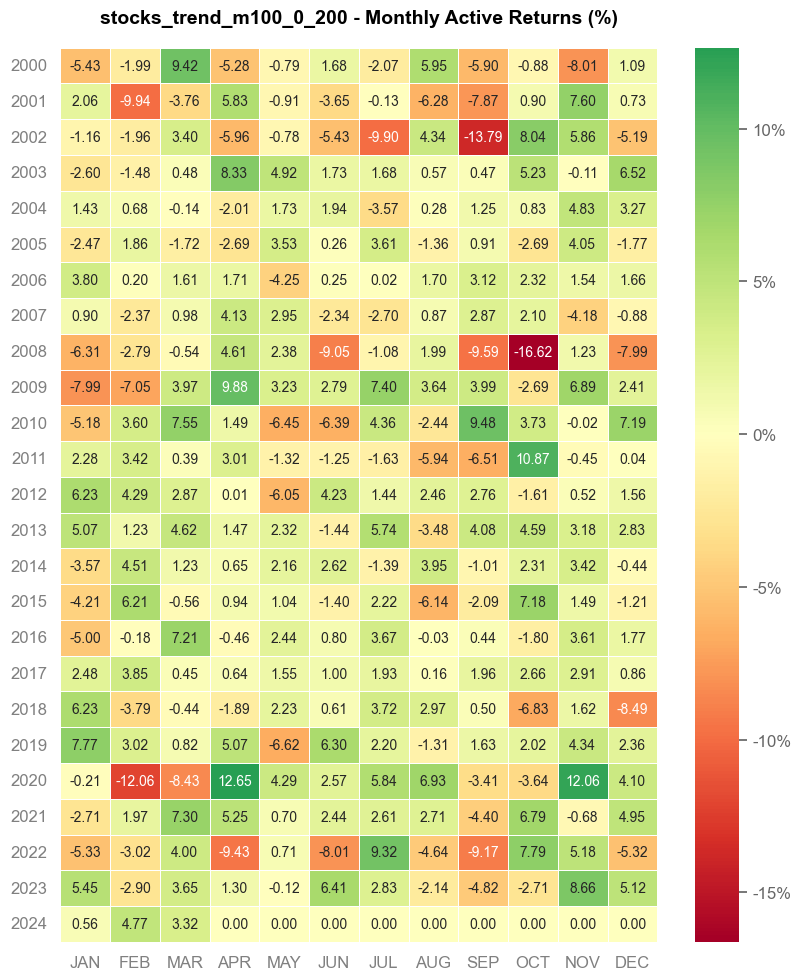

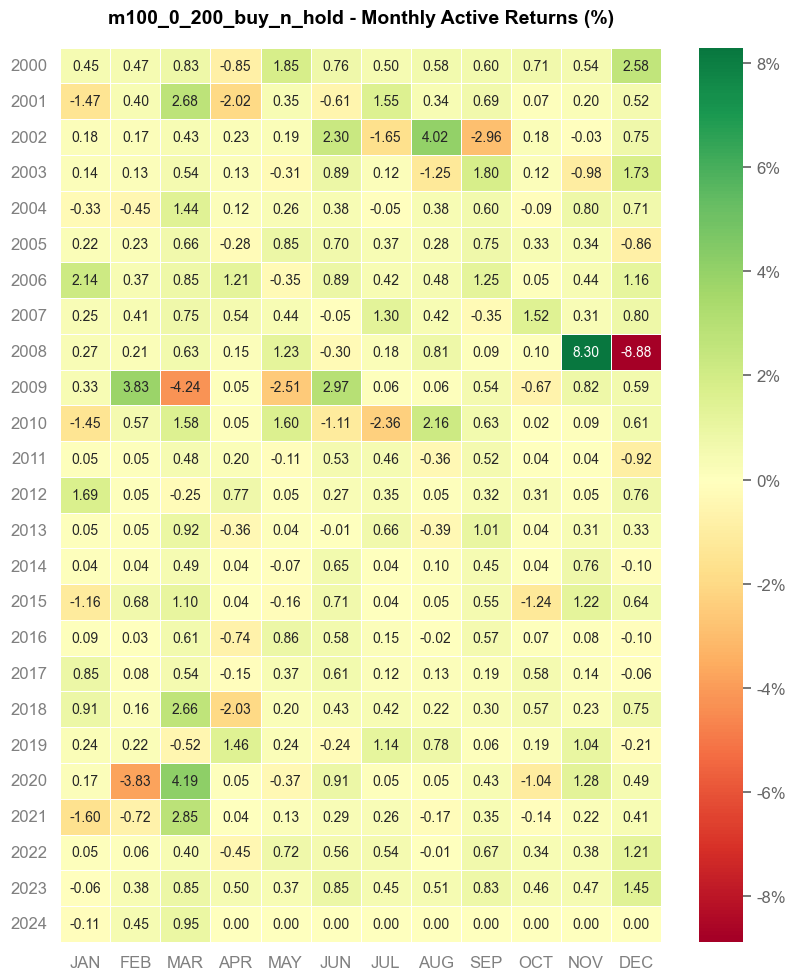

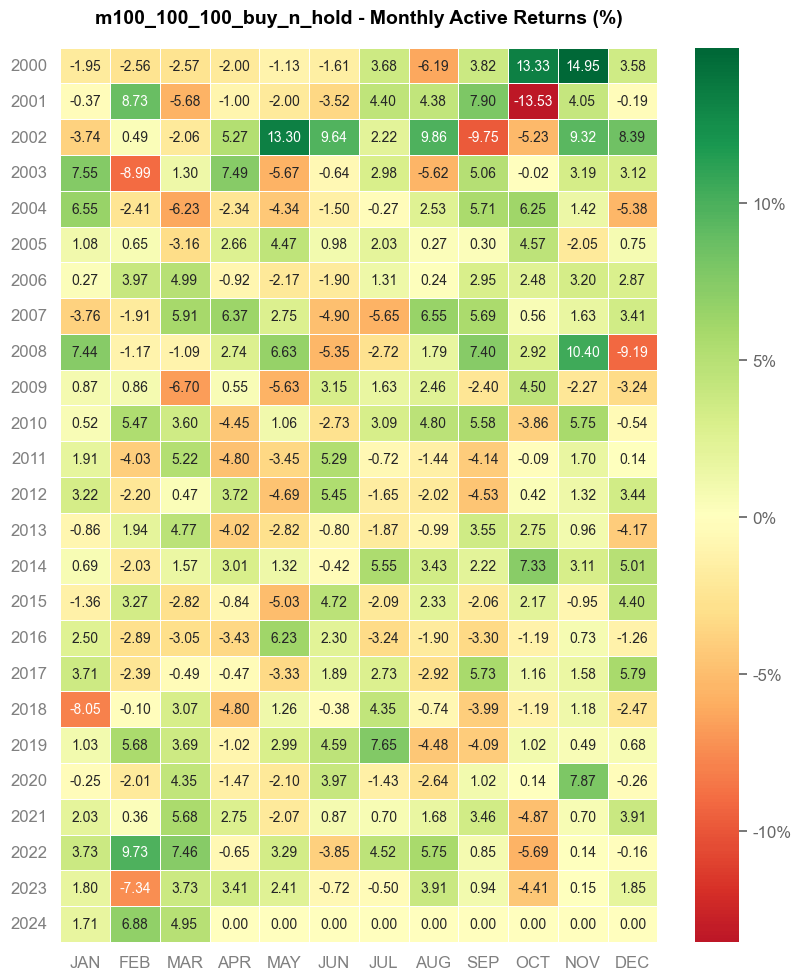

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1019: FutureWarning:

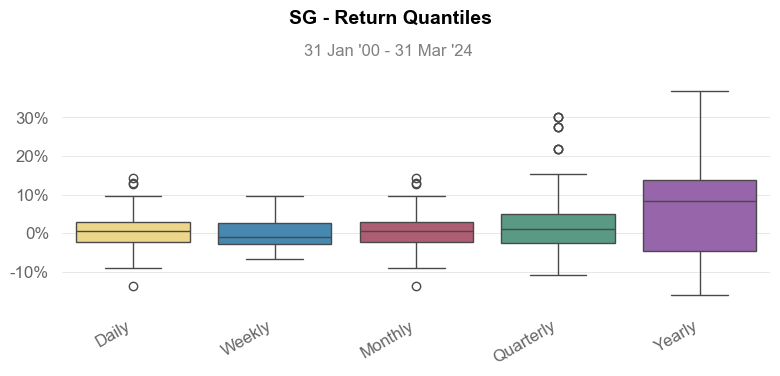

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1019: FutureWarning:

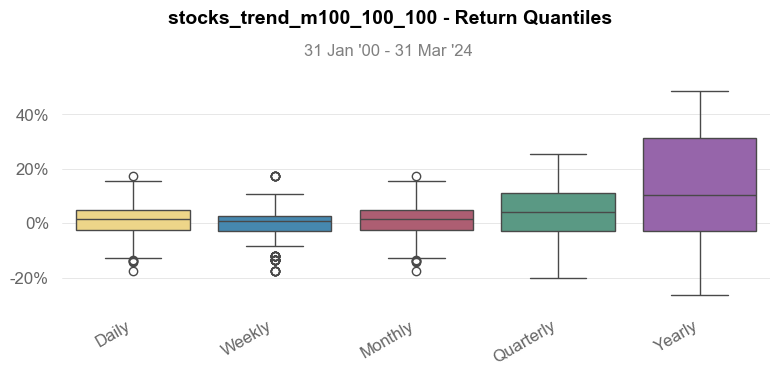

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1019: FutureWarning:

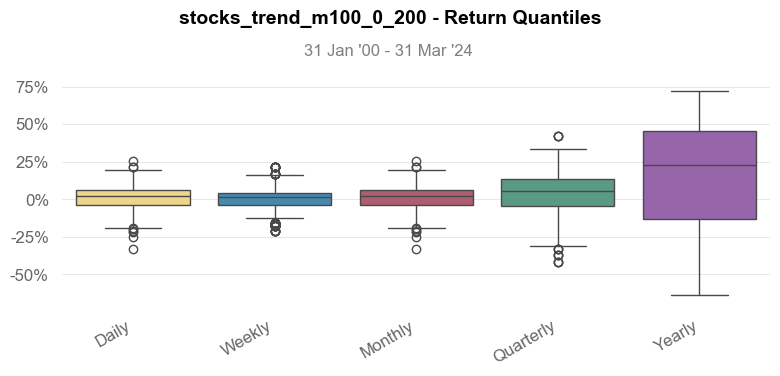

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1019: FutureWarning:

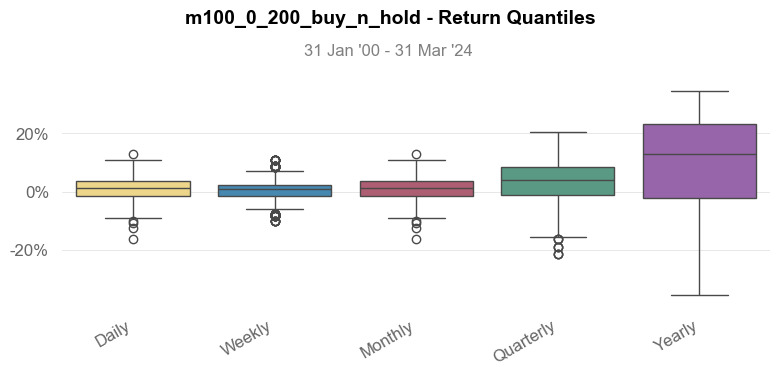

c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1016: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  port["Weekly"].ffill(inplace=True)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1018: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  port["Monthly"] = port["Daily"].resample("M").apply(apply_fnc)
c:\Users\Emile\mambaforge\envs\lcenv1\lib\site-packages\quantstats\_plotting\core.py:1019: FutureWarning:

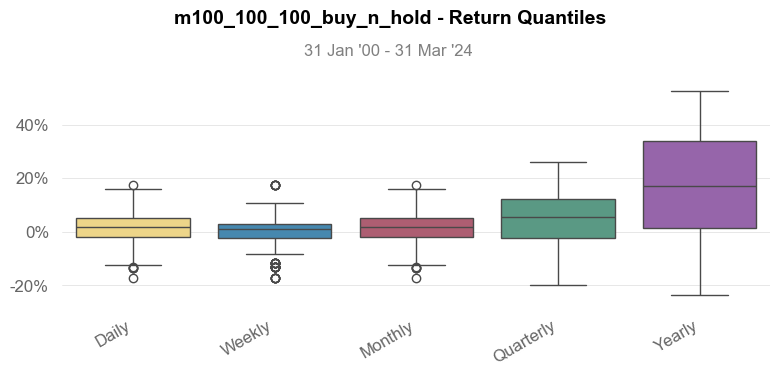

In [373]:
qs.reports.full(data1, benchmark="SPY")